This notebook goes through the entire process of our participation in the AICrowd challenge _Road Segmentation_. The notebook should be seen as a complement to the final report. It should be noted that even though we compare models in this notebook, the comparisons are not perfect as considerably more time is spent optimizing hyperparameters for the UNet than for the other models.

### Imports and Setup

This section contains the essential setup and imports for the project

In [ ]:
from baseline.helpers import *
import cv2
import numpy as np
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
sm.set_framework('tf.keras')
from seg_mod_unet.data_handling import extract_data, extract_data_test, extract_labels
from seg_mod_unet.helpers import patch_to_label, window_predict, img_float_to_uint8, save_predictions, masks_to_submission
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns

# Setting the style for plots using seaborn
sns.set()
sns.set_style("white")

Segmentation Models: using `tf.keras` framework.


## Generating testset

To accurately determine the effect of our experiements, we define a testset which will be used for all models. The testset will be the 10-split of the first data augmentation, i.e. the data/training/10-split folder. All images here are of size 256x256. It should be kept in mind that the final predictions will be done on 608x608 images so the results will not reflect the F1-score on AICrowd accurately. However, we experienced that the relative performance was generalizable. The tests will be done patchwise as this is how the final performance is evaluated at AICrowd.

In [ ]:
# path to test set
gt_path = 'data/training/groundtruth/10-split/'
files = os.listdir(gt_path)

# patch size equal to the one being used in AICrowd predictions
patch_size = 16

# defining threshold for converting patch to road
thr = 0.25

# saving each patch of groundtruth in the gts array
gts = []
for img in files:
    gt = mpimg.imread(os.path.join(gt_path, img))
    gt = np.expand_dims(gt[:,:,0], axis=2)
    for j in range(0, gt.shape[1], patch_size):
        for i in range(0, gt.shape[0], patch_size):
            patch = gt[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            gts.append(label)

We do also define an image that will be used for visually inspecting predictions throughout the notebook.

In [ ]:
# Defining path for one test image and its prediction
test_img_path = "data/training/images/10-split/satImage_095_Aug00.png"

# Reading the test image
test_img = mpimg.imread(test_img_path)

## Logistic Regression

The first model we implemented to start of the project was a simple logistic regression. For the logistic regression, we extract 2-dimensional features consisting of average gray color as well as variance from the images. The features are then used to, patch-wise, predict whether a 16x16 patch is road or not. The model is generated on the original images.

__Data loading__

In [4]:
# Path to original images
image_path = str(Path.cwd()) + "/data/original/images/"

# Loading original images
files = os.listdir(image_path)
n = len(files) 
print("Loading " + str(n) + " original images")
imgs = [mpimg.imread(image_path + files[i]) for i in range(n)]

# Path to groundtruth images
gt_dir = str(Path.cwd()) + "/data/original/groundtruth/"
print("Loading " + str(n) + " groundtruth images")

# Loading groundtruth images
gt_imgs = []
for i in range (n):
    img = mpimg.imread(gt_dir + files[i])
    try:
        gt_imgs.append(img[:,:,0])
    except:
        gt_imgs.append(img)

Loading 100 original images
Loading 100 groundtruth images


__Feature processing__

In [5]:
# Defining patchsize to be 16*16 pixels
patch_size = 16 

# Extracting patches from the images
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Percentage of pixels > 1 required to assign a foreground label to a patch
foreground_threshold = 0.25 

# Extracting features from patches
X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# Creating label list
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [6]:
# Splitting in training and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

__Model__

In [7]:
# Creating logistic regression model
logreg = LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight='balanced')

In [8]:
# Predicting on test set
y_hat = logreg.predict(x_test)

# Calculating f1-score for the test set
f1 = f1_score(y_test, y_hat)

print(f'F1-Score: {f1}')

F1-Score: 0.43260988509939813


We see that the logistic regression achieves a F1-score of 0.43 on the test set. This is not especially good and supports the hypothesis that a more complex model is needed.

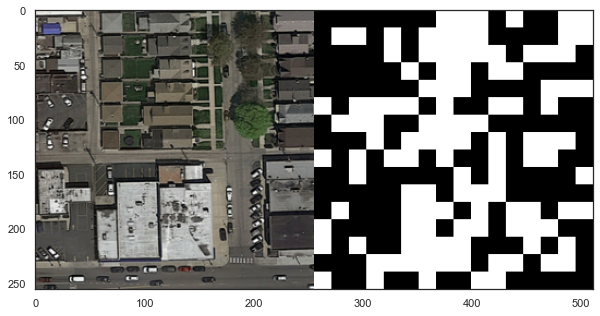

In [13]:
# Cropping test image to patches
test_patches = [img_crop(test_img, patch_size, patch_size)]

# Linearizing test images
test_patches = np.asarray([test_patches[i][j] for i in range(len(test_patches)) for j in range(len(test_patches[i]))])

# Extracting 2d features for test image
X_test = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# Generating prediction on test image
pred = logreg.predict(X_test)

# converting prediction to image
pred_log = label_to_img(256, 256, patch_size, patch_size, pred)

# Visualizing original test image and prediction
cimg = concatenate_images(test_img, pred_log)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Moreover, from visualizing the image and our prediction, we observe that the model is not especially accurate. 

## Baseline CNN

As we noted above, the logistic regression was not particulary successful. We did therefore decide to implement an improved baseline model. This model is based upon the code given by the course which implements a basic CNN with two convolutional layers and two pooling layers. The code can be found in the file `baseline.py` in the baseline folder. More information about the model can be found in the report. All credits for the code is due Aurelien Lucchi from ETH Zürich, as we have only made minor modifications. 

First, we run the model on the original dataset. The arguments in the script below specify that the model should indeed be run on the original data.

In [1]:
%run "baseline/baseline.py" False

Running model without data augmentation
(62500, 2)
Number of data points per class: c0 = 46309 c1 = 16191
Balancing training data...
Number of data points per class: c0 = 16191 c1 = 16191
Initialized!
Total number of iterations = 15179
Epoch 0
Minibatch loss: 2.865, learning rate: 0.010000
Minibatch error: 60.9%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 1
Minibatch loss: 1.659, learning rate: 0.010000
Minibatch error: 34.4%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 2
Minibatch loss: 1.672, learning rate: 0.009500
Minibatch error: 42.2%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 3
Minibatch loss: 1.575, learning rate: 0.009025
Minibatch error: 34.4%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 4
Minibatch loss: 1.670, learning rate: 0.008574
Minibatch error: 45.3%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 5
Minibatch loss: 1.607, learning rate: 0.008145
Minibatch error: 35.9%
M

c:\Users\Benjamin\Desktop\Skole\EPFL\ml-project-2-vikings_ml\baseline\handling_images.py:186: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)


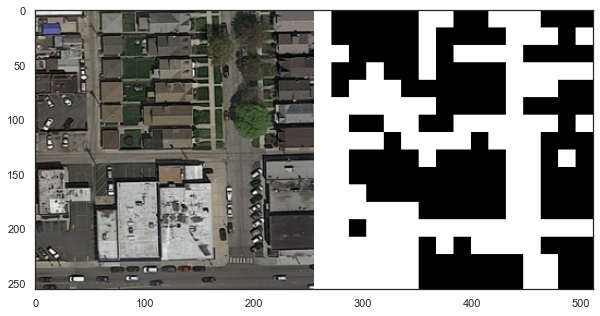

In [8]:
pred_cnn = mpimg.imread("predictions/69.png")

# Visualizing original test image and prediction
cimg = concatenate_images(test_img, pred_cnn)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

We observe that the model do not seem to perform well at all. Especially, it predicts road too scarcely.

In [9]:
# Defining paths to save predictions and load groundtruths
pred_path = 'predictions/'
files = os.listdir(pred_path)

# Initializing lists for storing predictions and groundtruths
preds = []

# calculating patchwise predictions for all iamges in the test set
for i in range(len(files)):
    # Reading in predicted images
    pred = mpimg.imread(os.path.join(pred_path, '%d.png' % (i+1)))
    # converting prediction to patches
    for j in range(0, pred.shape[1], patch_size):
        for i in range(0, pred.shape[0], patch_size):
            patch = pred[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            preds.append(label)

# Calculating f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the baseline CNN is %.3f"%f1)

The F1-score for the baseline CNN is 0.584


The F1-score for the model on the original data is 0.584. On AICrowd, it achieved a score of 0.598. To improve the predictions, we decided to apply feature agumentations. In the cells below, we run exactly the same model, but this time with feature augmentations.

In [1]:
%run "baseline/baseline.py" True

Running model with data augmentation


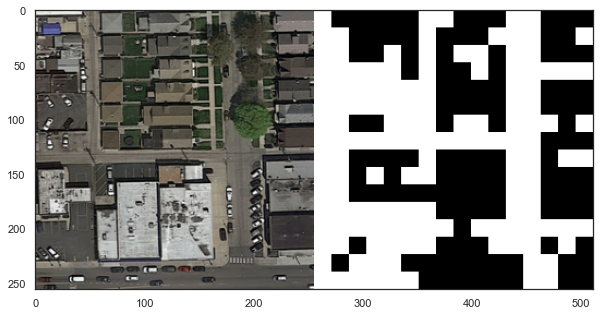

In [7]:
# Visualizing original test image and prediction
pred_cnn_aug = mpimg.imread("predictions/69.png")
cimg = concatenate_images(test_img, pred_cnn_aug)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [8]:
# Defining paths to save predictions and load groundtruths
pred_path = 'predictions/'
files = os.listdir(pred_path)

# Initializing lists for storing predictions and groundtruths
preds = []

#TODO: Test code if time
# calculating patchwise predictions for all iamges in the test set
for i in range(len(files)):
    # Reading in predicted images
    pred = mpimg.imread(os.path.join(pred_path, '%d.png' % (i+1)))
    # converting prediction to patches
    for j in range(0, pred.shape[1], patch_size):
        for i in range(0, pred.shape[0], patch_size):
            patch = pred[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            preds.append(label)

# Calculating f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the baseline CNN with feature augmentation is %.3f"%f1)

The F1-score for the baseline CNN with feature augmentation is 0.629


We observe that the data augmentation has drastically improved the baseline CNN, as it now score a F1-score of 0.629. On AICrowd, it scores 0.688.

## UNet

The next major improvement we got was through the use of a UNet. A description of UNet can be found in our report. We did first implement the UNet from scratch, but we switched to utlize the `segmentation_models` library as it was easier to change architecture this way. The following section contains first our results from creating the model from scratch and then our `segmentation_models` implementation.

#### __UNet from scratch__

In [ ]:
# loading the original UNet implementation
path_to_model = 'models/unet.h5'
model = load_model(path_to_model)

In [ ]:
# TODO: Test this code. Unknown if my functions works for Nikolai's model
# Defining path for test images
val_dir = os.path.join(os.path.join(str(Path.cwd()), 'data'), 'training') 
val_dir = os.path.join(os.path.join(val_dir, 'images'), '10-split/')

# Extracting the validation data
val_images = extract_data(val_dir)

# predicting on validation images
results = model.predict(val_images)

# Generating and saving the prediction masks for the validation set
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

In [ ]:
# Converting pixelwise predictions to patchwise predictions
y_pred_flattened = []
patch_size=16
thr = 0.13
for im in results:
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            y_pred_flattened.append(label)
y_pred_flattened = np.array(y_pred_flattened)

In [ ]:
# calculating groundtruth
gt_path = 'data/training/groundtruth/10-split/'
files = os.listdir(gt_path)

gts = []
for img in files:
    gt = mpimg.imread(os.path.join(gt_path, img))
    gt = np.expand_dims(gt[:,:,0], axis=2)
    for j in range(0, gt.shape[1], patch_size):
        for i in range(0, gt.shape[0], patch_size):
            patch = gt[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            gts.append(label)

In [ ]:
# Calculating f1-score
f1 = f1_score(gts, y_pred_flattened)

print("The F1-score for the original UNet is %.3f"%f1)

In [ ]:
# visually inspecting the quality of prediction
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00.png")
pred_unet = mpimg.imread("predictions/69.png")

# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_unet)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

### __Segmentation models UNet__

**Remark:** The training part of this is originally ran on Google Colab and not is rewritten for this notebook as it is too time-consuming to run without GPU. It should therefore not be attempted to run in this repository. Please follow the instructions in the `README` to retrain the model.

##### __Extracting data and masks__

In [6]:
# Defining paths to images and masks
train_data_path = '/content/data/training/images/'
train_labels_path = '/content/data/training/groundtruth/'

# Extracting the data and masks
x_train = extract_data(train_data_path)
y_train = extract_labels(train_labels_path)

In [7]:
# Splitting the dataset into two, one training set and one validation set
x_val = x_train[1360:]
y_val = y_train[1360:]
x_train = x_train[0:1360]
y_train = y_train[0:1360]

__Model__

In [8]:
# Defining backbone for the model
BACKBONE = 'resnet34'
# Downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocessing training and validation data
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [9]:
# Defining model, using 'imagenet' as weights to converge faster
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(256, 256, 3))

# Adding  L2 kernel regularizer
sm.utils.set_regularization(model, kernel_regularizer=keras.regularizers.l2(1))

# Compiling the model using Adam optimizer and Binary Cross Entropy with Jaccard loss
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(),'accuracy'],
)

# Saving the model thats scores best on the validation data
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/m6.h5", save_best_only=True)]

# Training the model for 50 epochs with batch size = 32
history = model.fit(x=x_train, y=y_train,
   epochs=50, batch_size=32,
   callbacks=callbacks,
   validation_data=(x_val,y_val)
)

85532672/85521592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
43/43 [==============================] - 78s 1s/step - loss: 1.0840 - iou_score: 0.3173 - f1-score: 0.4720 - accuracy: 0.6757 - val_loss: 3.7963 - val_iou_score: 8.4665e-09 - val_f1-score: 1.6905e-08 - val_accuracy: 0.7649
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.7195 - iou_score: 0.5270 - f1-score: 0.6897 - accuracy: 0.7358 - val_loss: 2.2874 - val_iou_score: 0.0330 - val_f1-score: 0.0639 - val_accuracy: 0.7649
Epoch 3/50
43/43 [==============================] - 42s 966ms/step - loss: 0.6146 - iou_score: 0.6012 - f1-score: 0.7506 - accuracy: 0.7446 - val_loss: 3.4945 - val_iou_score: 0.0094 - val_f1-score: 0.0187 - val_accuracy: 0.7649
Epoch 4/50
43/43 [==============================] - 41s 964ms/step - loss: 0.5686 - iou_score: 0.6349 - f1-score: 0.7764 - accuracy: 0.7489 - val_loss: 3.7957 - val_iou_score: 1.2973e-06 - val_f1-score: 2.5945e-06 - val_accuracy: 0.7649
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.

__Visualizing results__

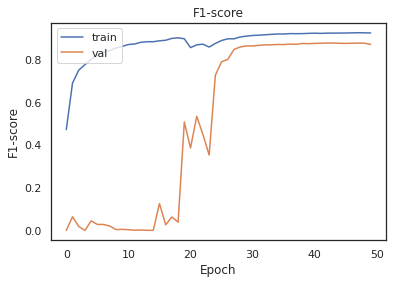

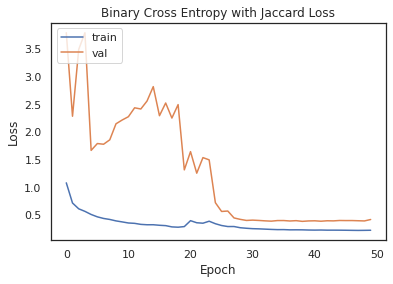

In [23]:
# F1-score for the model across epochs
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('f1_score.png')
plt.show()

# Loss for the model across epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy with Jaccard Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

We note that the model seem to reach a performance threshold from around 25 epochs.

__Testing__

In [15]:
# Generating predictions on the validation set
y_pred = model.predict((x_val))

# Defining patch_size to be used in predictions
patch_size = 16

Using validation set to find optimal threshold for defining a patch as road

In [17]:
# Defining a list of potential thresholds
thresholds = [0.01*i for i in range(0, 101)]

# List for saving f1-scores
f1s = []

# Saving highest f1-score 
highest = 0

# Iterating through each threshold and calculating F1-score and accuracy
for thr in thresholds:

  # Converting pixelwise predictions to patchwise predictions
  y_pred_flattened = []
  for im in y_pred:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_pred_flattened.append(label)
  y_pred_flattened = np.array(y_pred_flattened)

  # Converting mask to patchwise values
  y_val_flattened = []
  for im in y_val:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_val_flattened.append(label)

  # Calculating and storing f1-score and accuracy
  f1 = f1_score(y_val_flattened, y_pred_flattened)
  acc = accuracy_score(y_val_flattened, y_pred_flattened)
  f1s.append(f1)

  # Setting foreground_threshold for future predcitions to thr if thr gives the best f1-score
  if f1>highest:
    foreground_threshold=thr

  print("Threshold: %.2f, F1-score: %.4f, Accuracy: %.4f"%(thr, f1, acc))

Threshold: 0.00, F1-score: 0.5233, Accuracy: 0.3543
Threshold: 0.01, F1-score: 0.9750, Accuracy: 0.9844
Threshold: 0.02, F1-score: 0.9763, Accuracy: 0.9855
Threshold: 0.03, F1-score: 0.9765, Accuracy: 0.9859
Threshold: 0.04, F1-score: 0.9764, Accuracy: 0.9860
Threshold: 0.05, F1-score: 0.9773, Accuracy: 0.9866
Threshold: 0.06, F1-score: 0.9774, Accuracy: 0.9868
Threshold: 0.07, F1-score: 0.9767, Accuracy: 0.9866
Threshold: 0.08, F1-score: 0.9766, Accuracy: 0.9866
Threshold: 0.09, F1-score: 0.9774, Accuracy: 0.9872
Threshold: 0.10, F1-score: 0.9776, Accuracy: 0.9875
Threshold: 0.11, F1-score: 0.9775, Accuracy: 0.9875
Threshold: 0.12, F1-score: 0.9778, Accuracy: 0.9878
Threshold: 0.13, F1-score: 0.9779, Accuracy: 0.9879
Threshold: 0.14, F1-score: 0.9771, Accuracy: 0.9876
Threshold: 0.15, F1-score: 0.9765, Accuracy: 0.9874
Threshold: 0.16, F1-score: 0.9760, Accuracy: 0.9872
Threshold: 0.17, F1-score: 0.9754, Accuracy: 0.9871
Threshold: 0.18, F1-score: 0.9753, Accuracy: 0.9871
Threshold: 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Threshold: 0.99, F1-score: 0.0000, Accuracy: 1.0000
Threshold: 1.00, F1-score: 0.0000, Accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Plotting the F1-score by thresholds

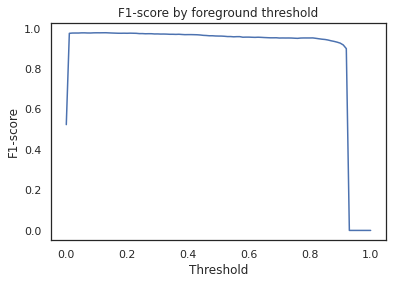

In [22]:
plt.plot(thresholds, f1s)
plt.title("F1-score by foreground threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.savefig("thr.png")
plt.show()

We see that most thresholds score the same, but the optimum, in intervals of 0.01, for this validation set is 0.13.

### Predicting

In [ ]:
# Loading the first model as it is not trained on the validation set used in this notebook
model = load_model('models/m1.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})

In [13]:
# Defining path for test images
val_dir = os.path.join(os.path.join(str(Path.cwd()), 'data'), 'training') 
val_dir = os.path.join(os.path.join(val_dir, 'images'), '10-split/')

In [15]:
# Defining backbone for the model
BACKBONE = 'resnet34'

# Downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)

In [23]:
# Extracting the validation set
val_images = extract_data(val_dir)
# Preprocessing the validation images
val_images = preprocess_input(val_images)

In [24]:
# Generating predictions for the test images
results = model.predict(val_images)

In [71]:
# Generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

In [28]:
# Converting pixelwise predictions to patchwise predictions
y_pred_flattened = []
patch_size=16
thr = 0.13
for im in results:
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            y_pred_flattened.append(label)
y_pred_flattened = np.array(y_pred_flattened)

In [58]:
gt_path = 'data/training/groundtruth/10-split/'
files = os.listdir(gt_path)

gts = []
for img in files:
    gt = mpimg.imread(os.path.join(gt_path, img))
    gt = np.expand_dims(gt[:,:,0], axis=2)
    for j in range(0, gt.shape[1], patch_size):
        for i in range(0, gt.shape[0], patch_size):
            patch = gt[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            gts.append(label)

In [63]:
# Calculating f1-score
f1 = f1_score(gts, y_pred_flattened)

print("The F1-score for the UNet with resnet34 backbone is %.3f"%f1)

The F1-score for the UNet with resnet34 backbone is 0.983


We see that the UNet model achieves a superior F1-score. One thing worth mentioning here is that the F1-score is much higher than the one we get on AICrowd. We hypothesize this is due to us testin on 256x256 images while we on AICrowd uses a window method to predict on 608x608 images.

Inspecting the prediction

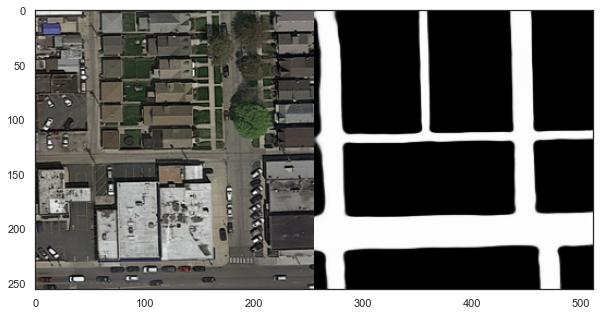

In [72]:
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00.png")
pred_unet = mpimg.imread("predictions/69.png")

# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_unet)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')